In [40]:
# Importing necessary libraries for data analysis and visualization

import pandas as pd  # Importing pandas library for data manipulation and analysis
import pymssql
import seaborn as sns  # Importing seaborn library for statistical data visualization
import matplotlib.pyplot as plt  # Importing matplotlib library for creating visualizations
import numpy as np  # Importing numpy library for numerical computations
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

column_names = [
    'Serial',
    'MostRecentBodyScore',
    'MostRecentMotionScore',
    'InbreedingCoefficient',
    'AgeAtCalvingInDays',
    'Milk',
    'MilkDays',
    'MilkFat',
    'MilkProtein',
    'Lactation',
    'StageOfLactation',
    'PreviousDaysOpen',
    'PreviousTimesBred',
    'CurrentTimesBred',
    'DIMAtBreeding',
    'StillBirth',
    'Abortion',
    'MultiBirth',
    'NaturalBreeding',
    'Pregnant',
    'Lameness',
    'Mastities',
    'Ketosis',
    'RetainedPlacentra',
    'DisplacedAbomasa',
    'Winter',
    'Spring',
    'Summer',
    'Fall'
]


def create_connection():
    server = "192.168.32.2\\SQLEXPRESS"
    database = "ModiranFarmer"
    username = "mmgh900"
    password = "0936"
    conn = pymssql.connect(server, username, password, database)

    return conn


conn = create_connection()
cursor = conn.cursor()

cursor.execute("""

        SELECT i.Serial,
       last_bc.Score                                            AS MostRecentBodyScore,
       last_ms.Score                                            AS MostRecentMotionScore,
       m.IntBlood                                               AS InbreedingCoefficient,
       DATEDIFF(day, m.EngBDate, cb.EngZDate)                   AS AgeAtCalvingInDays,
       sm.AllMilk                                               as Milk,
       sm.MilkDays                                              as MilkDays,
       sm.AllOil                                                as MilkFat,
       sm.AllPro                                                as MilkProtein,
       cb.MilkPeriod                                            AS Lactation,
       DATEDIFF(month, cb.EngZDate, i.EngTDate)                 AS StageOfLactation,
       DATEDIFF(day, ca.EngZDate, ib.EngTDate)                   AS PreviousDaysOpen,
       ptb.Count                                                AS PreviousTimesBred,
       ctb.Count                                                AS CurrentTimesBred,
       DATEDIFF(day, cb.EngZDate, i.EngTDate)                   AS DIMAtBreeding,
       CASE WHEN cb.Zsituation LIKE '%مرده%' THEN 1 ELSE 0 END  AS StillBirth,
       CASE WHEN cb.Zsituation LIKE '%سقط%' THEN 1 ELSE 0 END   AS Abortion,
       CASE WHEN cb.BrithKind LIKE '%ت%' THEN 0 ELSE 1 END      AS MultiBirth,
       CASE WHEN RTRIM(i.TKind) = 'طبیعي' THEN 1 ELSE 0 END     AS NaturalBreeding,
       CASE WHEN i.TDate = cc.PrInitDate THEN 1 ELSE 0 END      AS Pregnant,
       CASE WHEN l.Serial IS NOT NULL THEN 1 ELSE 0 END         AS Lameness,
       CASE WHEN mastites.Serial IS NOT NULL THEN 1 ELSE 0 END  AS Mastities,
       CASE WHEN ketosis.Serial IS NOT NULL THEN 1 ELSE 0 END   AS Ketosis,
       CASE WHEN retained.Serial IS NOT NULL THEN 1 ELSE 0 END  AS RetainedPlacentra,
       CASE WHEN displaced.Serial IS NOT NULL THEN 1 ELSE 0 END AS DisplacedAbomasa,
       CASE
           WHEN MONTH(i.EngTDate) IN (1, 2, 12) THEN 1
           WHEN MONTH(i.EngTDate) = 3 AND DAY(i.EngTDate) <= 20 THEN 1
           WHEN MONTH(i.EngTDate) = 12 AND DAY(i.EngTDate) >= 21 THEN 1
           ELSE 0
           END                                                  AS Winter,

       CASE
           WHEN MONTH(i.EngTDate) IN (4, 5) THEN 1
           WHEN MONTH(i.EngTDate) = 3 AND DAY(i.EngTDate) > 20 THEN 1
           WHEN MONTH(i.EngTDate) = 6 AND DAY(i.EngTDate) <= 20 THEN 1
           ELSE 0
           END                                                  AS Spring,

       CASE
           WHEN MONTH(i.EngTDate) IN (7, 8) THEN 1
           WHEN MONTH(i.EngTDate) = 6 AND DAY(i.EngTDate) > 20 THEN 1
           WHEN MONTH(i.EngTDate) = 9 AND DAY(i.EngTDate) <= 21 THEN 1
           ELSE 0
           END                                                  AS Summer,

       CASE
           WHEN MONTH(i.EngTDate) IN (10, 11) THEN 1
           WHEN MONTH(i.EngTDate) = 9 AND DAY(i.EngTDate) > 21 THEN 1
           WHEN MONTH(i.EngTDate) = 12 AND DAY(i.EngTDate) <= 20 THEN 1
           ELSE 0
           END                                                  AS Fall
        FROM [ModiranFarmer].[dbo].[Talghih] i
         JOIN [ModiranFarmer].[dbo].[Zayesh] cb ON i.Serial = cb.Serial AND i.MilkPeriod = cb.MilkPeriod + 1
        JOIN [ModiranFarmer].[dbo].[Main] m
                   ON cb.Serial = m.Serial
         LEFT JOIN [ModiranFarmer].[dbo].[StandardMilk] sm
                   ON sm.Serial = cb.Serial AND sm.MilkPeriod = cb.MilkPeriod

         OUTER APPLY (SELECT TOP (1) *
                      FROM [ModiranFarmer].[dbo].[Zayesh] c
                      WHERE c.Serial = i.Serial
                        AND c.ZDate < cb.PrInitDate
                      ORDER BY c.ZDate DESC) AS ca
         OUTER APPLY (SELECT TOP (1) *
                      FROM [ModiranFarmer].[dbo].[Zayesh] c
                      WHERE c.Serial = i.Serial
                        AND c.ZDate > cb.ZDate
                      ORDER BY c.ZDate ASC) AS cc
        OUTER APPLY (SELECT *
                      FROM [ModiranFarmer].[dbo].[Talghih] ib
                      WHERE ib.Serial = i.Serial
                        AND ib.TDate = cb.PrInitDate
                      ) AS ib
         OUTER APPLY (SELECT TOP (1) *
                      FROM [ModiranFarmer].[dbo].[BodyCondition] bc
                      WHERE bc.Serial = cb.Serial
                        AND bc.SDate >= cb.PrInitDate
                        AND bc.SDate <= i.TDate) AS last_bc
         OUTER APPLY (SELECT TOP (1) *
                      FROM [ModiranFarmer].[dbo].[MotionScore] ms
                      WHERE ms.Serial = cb.Serial
                        AND ms.SDate >= cb.PrInitDate
                        AND ms.SDate <= i.TDate) AS last_ms
         OUTER APPLY (SELECT COUNT(*) AS Count
                      FROM [ModiranFarmer].[dbo].[Talghih] pi
                      WHERE pi.Serial = i.Serial
                        AND pi.TDate > ca.ZDate
                        AND pi.TDate <= cb.PrInitDate) AS ptb
         OUTER APPLY (SELECT COUNT(*) AS Count
                      FROM [ModiranFarmer].[dbo].[Talghih] ci
                      WHERE ci.Serial = i.Serial
                        AND ci.TDate > cb.ZDate
                        AND ci.TDate <= i.TDate) AS ctb
         OUTER APPLY (SELECT TOP (1) *
                      FROM [ModiranFarmer].[dbo].[CaseHistory] ch
                      WHERE ch.Serial = i.Serial
                        AND ch.CaseDate >= cb.ZDate
                        AND ch.CaseDate >= i.TDate
                        AND RTRIM(ch.Resone) = 'لنگش') AS l
         OUTER APPLY (SELECT TOP (1) *
                      FROM [ModiranFarmer].[dbo].[CaseHistory] ch
                      WHERE ch.Serial = i.Serial
                        AND ch.CaseDate >= cb.ZDate
                        AND ch.CaseDate >= i.TDate
                        AND (
                                  RTRIM(ch.Resone) = 'اورام پستان'
                              OR RTRIM(ch.Resone) = 'ورم پستان قانقاريا'
                              OR RTRIM(ch.Resone) = 'ورم پستان فوق حاد'
                              OR RTRIM(ch.Resone) = 'ورم پستان حاد'
                              OR RTRIM(ch.Resone) = 'ورم پستان حاد'
                              OR RTRIM(ch.Resone) = 'ورم پستان گانگرنوز'
                              OR RTRIM(ch.Resone) = 'ورم پستان مزمن'
                              OR RTRIM(ch.Resone) = 'ورم پستان سپتيک'
                          )) AS mastites
         OUTER APPLY (SELECT TOP (1) *
                      FROM [ModiranFarmer].[dbo].[CaseHistory] ch
                      WHERE ch.Serial = i.Serial
                        AND ch.CaseDate >= cb.ZDate
                        AND ch.CaseDate >= i.TDate
                        AND (
                          RTRIM(ch.Resone) = 'كتوز'
                          )) AS ketosis
         OUTER APPLY (SELECT TOP (1) *
                      FROM [ModiranFarmer].[dbo].[CaseHistory] ch
                      WHERE ch.Serial = i.Serial
                        AND ch.CaseDate >= cb.ZDate
                        AND ch.CaseDate >= i.TDate
                        AND (
                          RTRIM(ch.Resone) = 'جفت ماندگي' OR RTRIM(WhatDocFind) = 'جفت مانده'
                          )) AS retained
         OUTER APPLY (SELECT TOP (1) *
                      FROM [ModiranFarmer].[dbo].[CaseHistory] ch
                      WHERE ch.Serial = i.Serial
                        AND ch.CaseDate >= cb.ZDate
                        AND ch.CaseDate >= i.TDate
                        AND (
                          RTRIM(ch.Resone) = 'جابجايي شيردان'
                          )) AS displaced

        WHERE i.TDate > cb.ZDate
        AND DATEDIFF(day, ca.EngZDate, ib.EngTDate) > 60 AND DATEDIFF(day, ca.EngZDate, ib.EngTDate) < 300

""")
rows = cursor.fetchall()
columns = [
    'Serial',
    'MostRecentBodyScore',
    'MostRecentMotionScore',
    'InbreedingCoefficient',
    'AgeAtCalvingInDays',
    'Milk',
    'MilkDays',
    'MilkFat',
    'MilkProtein',
    'Lactation',
    'StageOfLactation',
    'PreviousDaysOpen',
    'PreviousTimesBred',
    'CurrentTimesBred',
    'DIMAtBreeding',
    'StillBirth',
    'Abortion',
    'MultiBirth',
    'NaturalBreeding',
    'Pregnant',
    'Lameness',
    'Mastities',
    'Ketosis',
    'RetainedPlacentra',
    'DisplacedAbomasa',
    'Winter',
    'Spring',
    'Summer',
    'Fall'
]
data = pd.DataFrame(rows, columns=columns)

# Extracting Insementaion Season
data['AverageMilk'] = data['Milk'] / data['MilkDays']
# calculate ECM only for rows where all three columns are non-zero
mask = (data['Milk'] != 0) & (data['MilkFat'] != 0) & (data['MilkProtein'] != 0)
data.loc[mask, 'ECM'] = 0.327 * data.loc[mask, 'Milk'] + 12.95 * data.loc[mask, 'MilkFat'] + 7.65 * data.loc[
    mask, 'MilkProtein']
data["FatProteinRatio"] = data["MilkFat"] / data["MilkProtein"]
features = [
    'MostRecentBodyScore',
    'MostRecentMotionScore',
    # 'InbreedingCoefficient',
    'AgeAtCalvingInDays',
    # 'Milk',
    # 'MilkDays',
    # 'MilkFat',
    # 'MilkProtein',
    'Lactation',
    'StageOfLactation',
    'PreviousDaysOpen',
    'PreviousTimesBred',
    'CurrentTimesBred',
    'DIMAtBreeding',
    'StillBirth',
    'Abortion',
    'MultiBirth',
    'NaturalBreeding',
    'Pregnant',
    'Lameness',
    'Mastities',
    'Ketosis',
    'RetainedPlacentra',
    'DisplacedAbomasa',
    'Winter',
    'Spring',
    'Summer',
    'Fall',
    # "ECM",
    # "AverageMilk",
    # "FatProteinRatio"

]

numberical_features = [
    'MostRecentBodyScore',
    'MostRecentMotionScore',
    # 'InbreedingCoefficient',
    'AgeAtCalvingInDays',
    # 'Milk',
    # 'MilkDays',
    # 'MilkFat',
    # 'MilkProtein',
    'Lactation',
    'StageOfLactation',
    'PreviousDaysOpen',
    'PreviousTimesBred',
    'CurrentTimesBred',
    'DIMAtBreeding',
    # "ECM",
    # "AverageMilk",
    # "FatProteinRatio"
]

categorical_features = [
    'StillBirth',
    'Abortion',
    'MultiBirth',
    'NaturalBreeding',
    'Pregnant',
    'Lameness',
    'Mastities',
    'Ketosis',
    'RetainedPlacentra',
    'DisplacedAbomasa',
    'Winter',
    'Spring',
    'Summer',
    'Fall',
]
pure_data = data[features]
standard_data = pure_data.copy()  # Create a copy of the original DataFrame
# Handling outliers
for column in numberical_features:
    mean = standard_data[column].mean()
    std = standard_data[column].std()
    upper_bound = mean + 3 * std
    lower_bound = mean - 3 * std

    standard_data.loc[:, column] = standard_data.loc[:, column].clip(lower=lower_bound, upper=upper_bound)

standard_data.describe()
standard_data['AgeAtCalvingInDays'] = standard_data['AgeAtCalvingInDays'].where(
    standard_data['AgeAtCalvingInDays'] >= 0, np.nan)
missing_values_count = standard_data.isnull().sum()
filled_data = standard_data.copy()  # Create a copy of the original DataFrame
# fill NaN values with mean value of each column
for col in numberical_features:
    mean_val = filled_data[col].mean()
    filled_data[col].fillna(mean_val, inplace=True)

# Split the data into input features (X) and target variable (y)
X = filled_data.drop('Pregnant', axis=1)
y = filled_data['Pregnant']

# Load the dataset and split it into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



{0: 0.6833268821366364, 1: 1.8636843494325679}
Epoch 1/20
565/565 [==============================] - 7s 6ms/step - loss: 0.7218 - accuracy: 0.6386 - val_loss: 0.5706 - val_accuracy: 0.7235
Epoch 2/20
565/565 [==============================] - 3s 5ms/step - loss: 0.5921 - accuracy: 0.7169 - val_loss: 0.5667 - val_accuracy: 0.7235
Epoch 3/20
565/565 [==============================] - 3s 5ms/step - loss: 0.5713 - accuracy: 0.7332 - val_loss: 0.5653 - val_accuracy: 0.7235
Epoch 4/20
565/565 [==============================] - 3s 5ms/step - loss: 0.5634 - accuracy: 0.7354 - val_loss: 0.5646 - val_accuracy: 0.7235
Epoch 5/20
565/565 [==============================] - 3s 5ms/step - loss: 0.5607 - accuracy: 0.7356 - val_loss: 0.5645 - val_accuracy: 0.7235
Epoch 6/20
565/565 [==============================] - 3s 6ms/step - loss: 0.5577 - accuracy: 0.7353 - val_loss: 0.5633 - val_accuracy: 0.7235
Epoch 7/20
565/565 [==============================] - 3s 5ms/step - loss: 0.5578 - accuracy: 0.7354 -

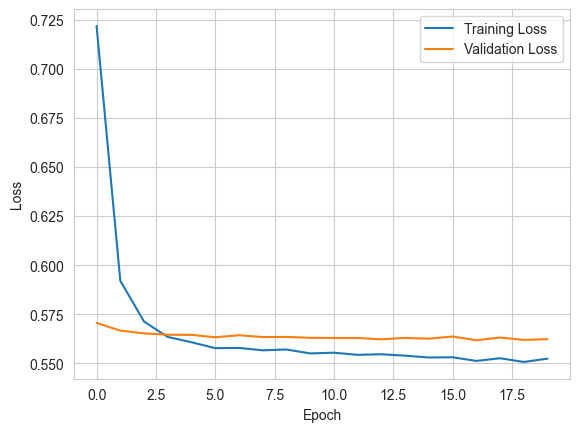

In [45]:
# Define the model
model = Sequential()

model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

from sklearn.utils.class_weight import compute_class_weight

# Get the class labels
class_labels = np.unique(y_train)

# Compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y)
class_weight_dict = dict(zip(class_labels, class_weights))
print(class_weight_dict)

# Train the model with the class weights
history = model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1,
          validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weight_dict)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
import numpy as np

class_distribution = np.mean(y_train, axis=0)
print(f'Class Distribution: {class_distribution}')

Class Distribution: 0.2646050011064395


In [46]:
np.mean(model.predict(X_test), axis=0)


177/177 [==============================] - 1s 3ms/step


array([0.26769626], dtype=float32)

In [44]:
model.predict(X_test)

177/177 [==============================] - 1s 3ms/step


array([[0.03790971],
       [0.5534988 ],
       [0.501499  ],
       ...,
       [0.47290486],
       [0.08108336],
       [0.4794736 ]], dtype=float32)

mode